In [67]:
import sys
sys.path.append('../')

from math import sqrt, pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ATARI.theory.resonance_statistics import make_res_par_avg

from ATARI.models.particle_pair import Particle_Pair

In [68]:
ac = 0.81271    # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider
D_avg = 4.99
ensemble = 'GOE'
if ensemble in ('GOE', 'NNE'):
    beta = 1
elif ensemble == 'GUE':
    beta = 2
elif ensemble == 'GSE':
    beta = 4
else:
    raise ValueError('Unsupported ensemble')

energy_range = [200,30000]
spin_groups = [ (3.0,1,0)]  # ,  (4.0,1,0)]
res_par_avg_1 = make_res_par_avg(J_ID=1,
                                 D_avg = D_avg, 
                            Gn_avg= 35.5, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = 1000, 
                            print = False)

average_parameters = {'3.0':res_par_avg_1}
Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   

resonance_ladder = Ta_pair.sample_resonance_ladder(energy_range, spin_groups, average_parameters, ensemble=ensemble)
resonance_ladder

,E,Gg,Gn1,J,chs,lwave,J_ID
0,201.248010,67.147435,39.438745,3.0,1.0,0.0,1.0
1,206.476163,68.658875,8.467804,3.0,1.0,0.0,1.0
2,208.600679,68.631524,98.332170,3.0,1.0,0.0,1.0
3,214.007229,62.908948,91.767869,3.0,1.0,0.0,1.0
4,223.283465,66.097115,5.559360,3.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...
5965,29973.398110,63.212855,79.446089,3.0,1.0,0.0,1.0
5966,29980.818189,63.099718,38.254770,3.0,1.0,0.0,1.0
5967,29985.659961,65.989703,16.304306,3.0,1.0,0.0,1.0
5968,29987.132414,67.849216,7.678994,3.0,1.0,0.0,1.0


In [69]:
def wignerPDF(x, mean_level_spacing:float=1.0, beta:int=1):
    """
    Wigner Distribution PDF.
    """
    if   beta == 1:
        coef = pi/(4*mean_level_spacing**2)
        return 2*coef * x * np.exp(-coef*x**2)
    elif beta == 2:
        coef1 = 4/(pi*mean_level_spacing**2)
        coef2 = coef1 * (8/(pi*mean_level_spacing))
        return coef2 * x**2 * np.exp(-coef1*x**2)
    elif beta == 4:
        coef1 = 64/(9*pi*mean_level_spacing**2)
        coef2 = 262144/(729*pi**3*mean_level_spacing**5)
        return coef2 * x**4 * np.exp(-coef1*x**2)
    else:
        raise NotImplementedError(f'beta = {beta} has not been implemented. Choose beta = 1, 2, or 4.')

def levelSpacingRatioPDF(ratio:float, beta:int=1):
    """
    This function returns the probability density on the ensemble's nearest level-spacing ratio,
    evaluated at `ratio`. The ensemble can be chosen from GOE, GUE, and GSE for `beta` = 1, 2, or
    4, respectively.

    Source: https://arxiv.org/pdf/1806.05958.pdf (Eq. 1)

    Inputs:
    ------
    ratio :: float or float array
        The nearest level-spacing ratio(s).

    beta  :: 1, 2, or 4
        The parameter that determines the assumed ensemble. For GOE, GUE, and GSE, `beta` = 1, 2,
        or 4, respectively. The default is 1 (GOE).

    Returns:
    -------
    level_spacing_ratio_pdf :: float or float array
        The probability density (or densities) evaluated at the the provided level-spacing
        ratio(s).
    """
    if   beta == 1:
        C_beta = 27/8
    elif beta == 2:
        C_beta = 81*sqrt(3)/(4*pi)
    elif beta == 4:
        C_beta = 729*sqrt(3)/(4*pi)
    else:
        raise ValueError('"beta" can only be 1, 2, or 4.')
    level_spacing_ratio_pdf = C_beta * (ratio+ratio**2)**beta / (1+ratio+ratio**2)**(1+(3/2)*beta)
    return level_spacing_ratio_pdf

def deltaMehta3(E, EB:tuple):
    """
    Finds the Dyson-Mehta ∆3 metric for the given data.

    Source: https://arxiv.org/pdf/2011.04633.pdf (Eq. 21 & 22)

    Let `L` be the number of recorded resonances in the ladder.

    Inputs:
    ------
    E  : float [L]
        The recorded resonance energies.
    
    EB : float [2]
        The lower and upper energies for the resonance ladder.

    Returns:
    -------
    delta_3 : float
        The Dyson-Mehta ∆3 metric.
    """

    E = np.sort(E) # sort energies if not already sorted
    z = (E-EB[0])/(EB[1]-EB[0]) # renormalize energies
    s1 = np.sum(z)
    s2 = np.sum(z**2)
    a = np.arange( len(z)-1, -1, -1 )
    s3 = np.sum((2*a+1)*z)
    delta_3 = 6*s1*s2 - 4*s1**2 - 3*s2**2 + s3
    return delta_3

def predictedDeltaMehta3(n:int):
    """
    Source: http://home.ustc.edu.cn/~zegang/pic/Mehta-Random-Matrices.pdf
    """

    return pi**(-2) * (np.log(n) - 0.0687)

def levelSpacingRatioPDF(ratio:float, beta:int=1):
    """
    This function returns the probability density on the ensemble's nearest level-spacing ratio,
    evaluated at `ratio`. The ensemble can be chosen from GOE, GUE, and GSE for `beta` = 1, 2, or
    4, respectively.

    Source: https://arxiv.org/pdf/1806.05958.pdf (Eq. 1)

    Inputs:
    ------
    ratio :: float or float array
        The nearest level-spacing ratio(s).

    beta  :: 1, 2, or 4
        The parameter that determines the assumed ensemble. For GOE, GUE, and GSE, `beta` = 1, 2,
        or 4, respectively. The default is 1 (GOE).

    Returns:
    -------
    level_spacing_ratio_pdf :: float or float array
        The probability density (or densities) evaluated at the the provided level-spacing
        ratio(s).
    """
    if   beta == 1:
        C_beta = 27/8
    elif beta == 2:
        C_beta = 81*sqrt(3)/(4*pi)
    elif beta == 4:
        C_beta = 729*sqrt(3)/(4*pi)
    else:
        raise ValueError('"beta" can only be 1, 2, or 4.')
    level_spacing_ratio_pdf = C_beta * (ratio+ratio**2)**beta / (1+ratio+ratio**2)**(1+(3/2)*beta)
    return level_spacing_ratio_pdf

In [70]:
energies = resonance_ladder['E'].to_numpy()
energy_bounds = energy_range

Calculated Dyson-Mehta ∆3 = 0.91811
Predicted Dyson-Mehta ∆3  = 0.87398



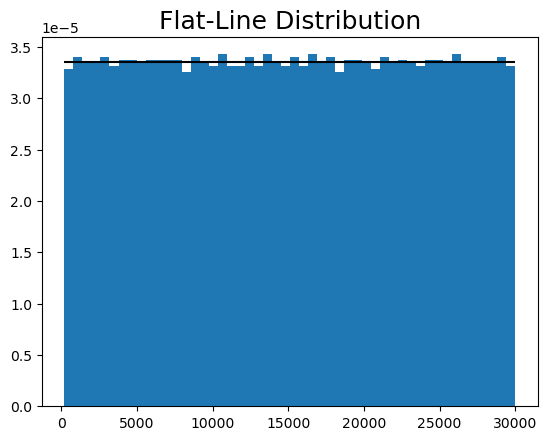

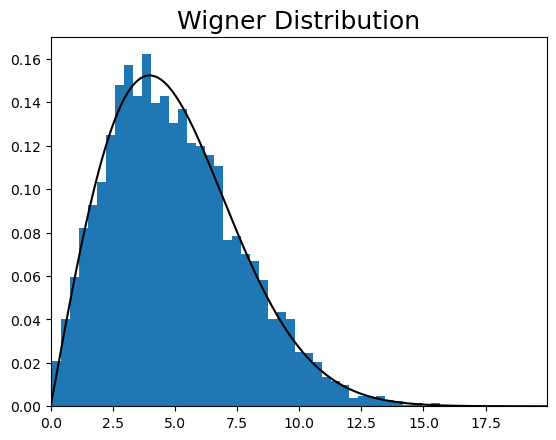

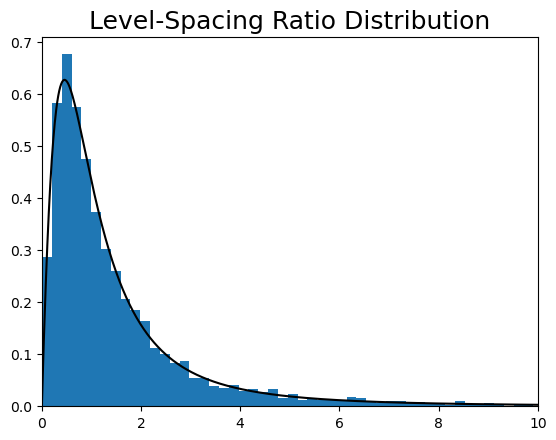

In [71]:
delta_3 = deltaMehta3(energies, energy_bounds)
delta_3_predicted = predictedDeltaMehta3(len(energies))
print(f'Calculated Dyson-Mehta ∆3 = {delta_3:.5f}')
print(f'Predicted Dyson-Mehta ∆3  = {delta_3_predicted:.5f}')
print()

plt.figure(1)
plt.clf()
plt.hist(energies, 50, density=True)
plt.hlines(1/(energy_bounds[1]-energy_bounds[0]), energy_bounds[0], energy_bounds[1], colors='k', linestyles='-')
plt.title('Flat-Line Distribution', fontsize=18)
plt.show()

X_max = 4*D_avg
level_spacings = energies[1:] - energies[:-1] # level-spacing
X = np.linspace(0, X_max, 1000)
plt.figure(2)
plt.clf()
plt.hist(level_spacings, 50, density=True)
plt.plot(X, wignerPDF(X, mean_level_spacing=D_avg, beta=beta), '-k')
plt.xlim(0,X_max)
plt.title('Wigner Distribution', fontsize=18)
plt.show()

X_max = 10
level_spacing_ratios = level_spacings[1:]/level_spacings[:-1] # level-spacing ratios
level_spacing_ratios = level_spacing_ratios[level_spacing_ratios < X_max]
X = np.linspace(0, X_max, 1000)
plt.figure(3)
plt.clf()
plt.hist(level_spacing_ratios, 50, density=True)
plt.plot(X, levelSpacingRatioPDF(X, beta=beta), '-k')
plt.xlim(0,X_max)
plt.title('Level-Spacing Ratio Distribution', fontsize=18)
plt.show()